# 1- Découverte et préparation des données

## 1.1 - Installation des packages

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive/")
print(os.getcwd())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import warnings
from sklearn.neighbors import DistanceMetric
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from tabulate import tabulate
from sklearn.decomposition import PCA

Mounted at /content/drive/
/content


## 1.2 - Découverte des données

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Projet_IA_3A/stat_finale.csv")
print("Le nombre d'instances dans la base de données est de : ", len(data))
print("Le nombre de features est de : ", data.shape[1])
data.loc[data['longitude'] <-10, 'longitude'] = 2
data.loc[data['longitude'] >13, 'longitude'] = 2
data.loc[data['longitude']==2, 'longitude'] = data['longitude'].median()
data.loc[data['longitude']==0, 'longitude'] = data['longitude'].median()
data.loc[data['latitude'] <30, 'latitude'] = 45
data.loc[data['latitude']>60, 'latitude'] = 45
data.loc[data['latitude']==45, 'latitude'] = data['latitude'].mean()
data.loc[data['latitude']==0, 'latitude'] = data['latitude'].mean()

Le nombre d'instances dans la base de données est de :  73643
Le nombre de features est de :  22


In [ ]:
print("Le nombre d'accident indemne est de : ", int(data['descr_grav'][data['descr_grav'] == 3].sum()/3))
print("Le nombre d'accident blessé léger est de : ", int(data['descr_grav'][data['descr_grav'] == 2].sum()/2))
print("Le nombre d'accident blessé hospitalisé est de : ", data['descr_grav'][data['descr_grav'] == 1].sum())
print("Le nombre d'accident mortel est de : ", int(data['descr_grav'][data['descr_grav'] == 4].sum()/4))

Le nombre d'accident indemne est de :  31004
Le nombre d'accident blessé léger est de :  25672
Le nombre d'accident blessé hospitalisé est de :  14891
Le nombre d'accident mortel est de :  2076


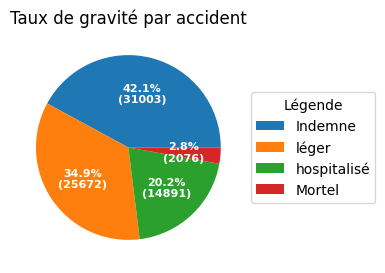

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

grav_acc = ["31004 / Indemne",
            "25672 / Blessé léger",
            "14891 / Blessé hospitalisé",
            "2076 / Mortel"]

data_pie = [float(x.split()[0]) for x in grav_acc]
legend = [x.split()[-1] for x in grav_acc]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data_pie, autopct=lambda pct: func(pct, data_pie),
                                  textprops=dict(color="w"))

ax.legend(wedges, legend,
          title="Légende",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Taux de gravité par accident")

plt.show()

## 1.3 - Préparation des données

In [ ]:
pd.to_datetime(data['date'], format="%Y-%m-%d")

0       2009-01-14 08:45:00
1       2009-01-06 11:30:00
2       2009-01-06 17:00:00
3       2009-01-31 20:00:00
4       2009-02-18 17:45:00
                ...        
73638   2009-12-11 18:45:00
73639   2009-12-22 10:00:00
73640   2009-12-26 21:00:00
73641   2009-12-22 12:20:00
73642   2009-10-29 14:40:00
Name: date, Length: 73643, dtype: datetime64[ns]

# 2 - Apprentissage non-supervisé

## 2.1 - Réduction de dimension

### 2.1.1 - Corrélation entre attributs et suppression manuelle de quelques features

<ipython-input-6-9efe58c9dc32>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrice_correlation = data.corr()


<Axes: >

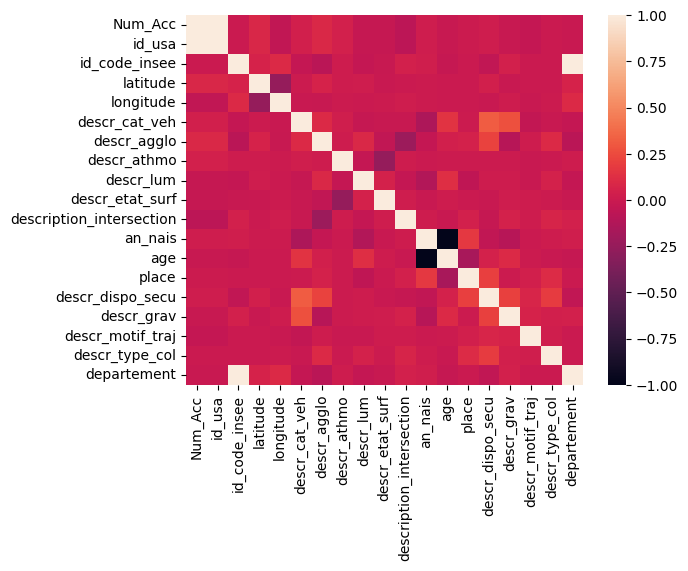

In [ ]:
matrice_correlation = data.corr()
sns.heatmap(matrice_correlation)

In [ ]:
print("### TEST CORRELATION > 0.75 ####\n")
for i in matrice_correlation:
  for j in matrice_correlation[i]:
    if j >= 0.75 and j!= 1:
      print(i,j)
    if j<=-0.75 and j!=-1:
      print(i,j)

print("\n### TEST CORRELATION > 0.5 ####\n")
for i in matrice_correlation:
  for j in matrice_correlation[i]:
    if j >= 0.5 and j!=1:
      print(i,j)
    if j<=-0.5 and j!=-1:
      print(i,j)

### TEST CORRELATION > 0.75 ####

Num_Acc 0.9999959213788927
id_usa 0.9999959213788927
id_code_insee 0.9999754324787202
an_nais -1.0000000000000004
age -1.0000000000000004
departement 0.9999754324787202

### TEST CORRELATION > 0.5 ####

Num_Acc 0.9999959213788927
id_usa 0.9999959213788927
id_code_insee 0.9999754324787202
an_nais -1.0000000000000004
age -1.0000000000000004
departement 0.9999754324787202


Corrélations entre :
  - Num_Acc/id_usa
  - id_code_insee/departement
  - latitude/longitude
  - an_nais/age

Donc suppression de 4 colonnes

In [ ]:
data_nett = data.copy()
if {'Num_Acc'}.issubset(data_nett.columns):
  data_nett.drop('Num_Acc', inplace=True, axis=1)
  print("Colonne Num_Acc supprimée")
if {'departement'}.issubset(data_nett.columns):
  data_nett.drop('departement', inplace=True, axis=1)
  print("Colonne departement supprimée")
if {'latitude'}.issubset(data_nett.columns):
  data_nett.drop('latitude', inplace=True, axis=1)
  print("Colonne latitude supprimée")
if {'an_nais'}.issubset(data_nett.columns):
  data_nett.drop('an_nais', inplace=True, axis=1)
  print("Colonne an_nais supprimée")

pourcent_red=(4*100/22)
print("Le pourcentage de réduction est de : " ,round(pourcent_red, 2), "%")

Colonne Num_Acc supprimée
Colonne departement supprimée
Colonne latitude supprimée
Colonne an_nais supprimée
Le pourcentage de réduction est de :  18.18 %


<ipython-input-9-5a9f68724746>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrice_correlation = data_nett.corr()


<Axes: >

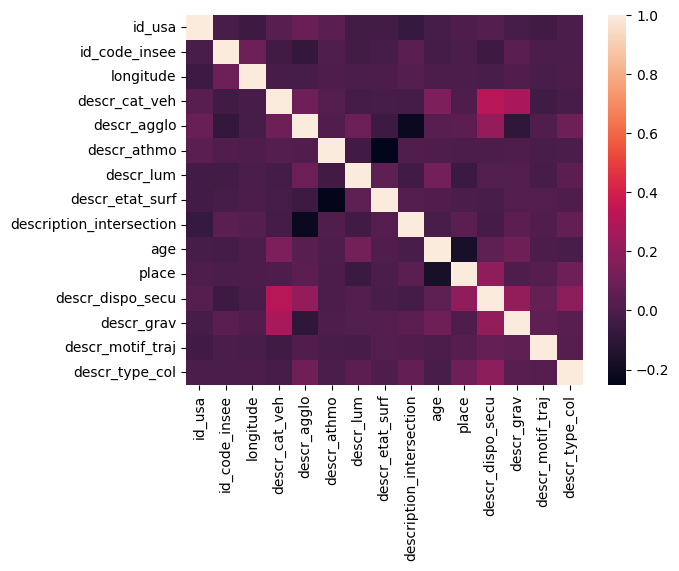

In [ ]:
matrice_correlation = data_nett.corr()
sns.heatmap(matrice_correlation)

In [ ]:
print("### TEST CORRELATION > 0.75 ####\n")
for i in matrice_correlation:
  for j in matrice_correlation[i]:
    if j >= 0.75 and j!= 1:
      print(i,j)
    if j<=-0.75 and j!=-1:
      print(i,j)

print("\n### TEST CORRELATION > 0.5 ####\n")
for i in matrice_correlation:
  for j in matrice_correlation[i]:
    if j >= 0.5 and j!=1:
      print(i,j)
    if j<=-0.5 and j!=-1:
      print(i,j)

### TEST CORRELATION > 0.75 ####


### TEST CORRELATION > 0.5 ####



Nous n'avons finalement plus de corrélation

### 2.1.2 - Utilisation de PCA avec scikit-learn (BONUS)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73643 entries, 0 to 73642
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   73643 non-null  int64  
 1   num_veh                   73643 non-null  object 
 2   id_usa                    73643 non-null  int64  
 3   date                      73643 non-null  object 
 4   ville                     73643 non-null  object 
 5   id_code_insee             73643 non-null  int64  
 6   latitude                  73643 non-null  float64
 7   longitude                 73643 non-null  float64
 8   descr_cat_veh             73643 non-null  int64  
 9   descr_agglo               73643 non-null  int64  
 10  descr_athmo               73643 non-null  int64  
 11  descr_lum                 73643 non-null  int64  
 12  descr_etat_surf           73643 non-null  int64  
 13  description_intersection  73643 non-null  int64  
 14  an_nai

In [ ]:
X = data.loc[:, ['Num_Acc',
                 'id_usa',
                 'id_code_insee',
                 'latitude',
                 'longitude',
                 'descr_cat_veh',
                 'descr_agglo',
                 'descr_athmo',
                 'descr_lum',
                 'descr_etat_surf',
                 'description_intersection',
                 'an_nais',
                 'age',
                 'place',
                 'descr_dispo_secu',
                 'descr_grav',
                 'descr_motif_traj',
                 'descr_type_col',
                 'departement']] .copy()
X = np.array(X)
pca = PCA()
pca.fit(X)
X = pca.fit_transform(X)
print(X)

[[-8.33822155e+04  1.34333725e+04  2.53527979e+02 ...  1.01014209e+00
  -9.42508818e-02  9.42508768e-14]
 [-8.23083861e+04 -1.56894609e+04  1.91939233e+02 ...  6.07710895e-01
   3.01651773e-02  5.75387648e-14]
 [-8.23070649e+04 -1.56894665e+04  1.91423895e+02 ...  6.20081793e-01
   3.18526345e-02  1.02244096e-13]
 ...
 [ 9.79386052e+04 -4.06354617e+04 -1.75897857e+02 ... -1.85749191e-01
   4.97770198e-02  8.00126072e-14]
 [ 9.79417514e+04 -4.06354731e+04 -1.75051659e+02 ... -3.18696107e-01
   6.11679349e-02  8.13621136e-14]
 [ 9.79848933e+04 -4.06356573e+04 -1.71194137e+02 ... -2.07475337e-01
   7.66814430e-02  7.81203577e-14]]


## 2.2 - Partitionnement (clustering)

### 2.2.1 - Objet KMeans from scratch

In [ ]:
# Création de l'objet Kmeans_from_scratch
class KMeans_from_scratch:
  # Constructeur de la classe
  def __init__(self, n_clusters, max_iter=100, distance='euclidean'):
    """Constructeur de la classe Kmeans_from_scratch

    Parameters
    -------------------------------------------------
    n_clusters : int
      Nombre de clusters du Kmeans
    max_iter : int
      Nombre d'itétations que sont mis à jour les centroides
    distance : str (euclidean, manhattan, haversine)
      Méthode de calcul de la distance entre le centroide et les points

    Returns
    -------------------------------------------------
    Kmeans_from_scratch
      Objet Kmeans
      """
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.distance = distance

  # Méthode fit de l'objet k-means
  def fit(self, X):
    self.centroides = self._initialisation_centroides(X)
    for _ in range(self.max_iter):
      # On attribue les points à chaque cluster
      labels = self._assignation_labels(X, self.centroides)
      # On met à jour les centroides
      new_centroides = self._update_centroides(X, labels)
      # On vérifie la convergence
      if np.allclose(self.centroides, new_centroides):
        break
      self.centroids = new_centroides
      self.labels = self._assignation_labels(X, self.centroides)

  # Méthode fit_predict
  def fit_predict(self, X):
        self.fit(X)
        return self.labels

  # Méthode d'initialisation des centroides
  def _initialisation_centroides(self, X):
    # Initialisation aléatoire du centroide
    indices = np.random.choice(X.shape[0], size=self.n_clusters, replace=False)
    return X[indices]

  # Méthode d'assignation des labels
  def _assignation_labels(self, X, centroides):
    if self.distance == 'euclidean':
      distances = self._dist_euclidienne(X, centroides)
    elif self.distance == 'manhattan':
      distances = self._dist_manhattan(X, centroides)
    elif self.distance == 'haversine':
      distances = self._dist_haversine(X, centroides)
    return np.argmin(distances, axis=-1)

  # Méthode de mise à jour des centroides
  def _update_centroides(self, X, labels):
    new_centroides = np.zeros_like(self.centroides)
    for i in range(self.n_clusters):
      cluster = X[labels == i]
      if cluster.size > 0:
        new_centroides[i] = np.mean(cluster, axis=0)
    return new_centroides

  # Distance euclidienne
  def _dist_euclidienne(self, X, centroides):
    return np.linalg.norm(X[:, np.newaxis] - centroides, axis=-1)

  # Distance manhattan
  def _dist_manhattan(self, X, centroides):
    return np.sum(np.abs(X[:, np.newaxis] - centroides), axis=-1)

  def _dist_haversine(self, coordinates1, coordinates2):
        dist = DistanceMetric.get_metric('haversine')
        coords_rad1 = np.radians(coordinates1)
        coords_rad2 = np.radians(coordinates2)
        distances = dist.pairwise(coords_rad1, coords_rad2)
        return distances


### 2.2.2 - KMeans from scratch euclidien

In [ ]:
# Transformation des latitudes et longitudes en numpy object pour pouvoir utiliser la méthode fit
latitude = np.array(data['latitude'])
longitude = np.array(data['longitude'])

# Création d'une seule matrice comportant longitudes et latitudes
coordonnees = np.column_stack((latitude, longitude))

# Création de notre objet Kmeans_from_scratch avec la distance en euclidien
k = 20
kmeans = KMeans_from_scratch(k, 100, 'euclidean')
kmeans.fit(coordonnees)
labels = kmeans.labels
centroides = kmeans.centroides
print(f"Clustering avec k = {k}:")
print("Labels:", labels)
print("Centroids:", centroides)

# Création d'une figure de carte avec Plotly et Mapbox
fig_eucl = go.Figure()

# Ajoute des centroïdes à la carte
for centroide in centroides:
    fig_eucl.add_trace(go.Scattermapbox(
        lat=[centroide[0]],
        lon=[centroide[1]],
        mode='markers',
        marker=dict(size=10, color='red'),
        text=['Centroïde'],
    ))
fig_eucl.update_layout(
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=46.6, lon=1.9),
        zoom=5,
    ),
)

# Afficher la carte
fig_eucl.show()


Clustering avec k = 20:
Labels: [5 3 3 ... 3 3 3]
Centroids: [[ 4.92500000e+01 -6.83333000e-01]
 [ 4.84000000e+01  1.66670000e-02]
 [ 4.66167000e+01  4.33333000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.65833000e+01  2.66667000e-01]
 [ 4.76333000e+01 -2.13333000e+00]
 [ 4.65833000e+01  2.66667000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.92667000e+01 -4.50000000e-01]
 [ 4.89833000e+01  8.13333000e+00]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.89667000e+01  9.33333000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.84333000e+01 -2.23333000e+00]
 [ 4.33583000e+01 -1.77500000e+00]
 [ 4.59783566e+01  7.16667000e-01]
 [ 4.59783566e+01  7.16667000e-01]]


### 2.2.3 - KMeans from scratch manhattan

In [ ]:
# Création de notre objet Kmeans_from_scratch avec la distance en manhattan
k = 20
kmeans = KMeans_from_scratch(k, 100, 'manhattan')
kmeans.fit(coordonnees)
labels = kmeans.labels
centroides = kmeans.centroides
print(f"Clustering avec k = {k}:")
print("Labels:", labels)
print("Centroids:", centroides)

# Créatioon d'une figure de carte avec Plotly et Mapbox
fig_man = go.Figure()

# Ajoute des centroïdes à la carte
for centroide in centroides:
    fig_man.add_trace(go.Scattermapbox(
        lat=[centroide[0]],
        lon=[centroide[1]],
        mode='markers',
        marker=dict(size=10, color='red'),
        text=['Centroïde'],
    ))
fig_man.update_layout(
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=46.6, lon=1.9),
        zoom=5,
    ),
)

# Afficher la carte
fig_man.show()

Clustering avec k = 20:
Labels: [6 0 0 ... 0 0 0]
Centroids: [[45.97835662  0.716667  ]
 [46.2        -1.16667   ]
 [45.97835662  0.716667  ]
 [48.2667     -1.4       ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [47.4833     -1.23333   ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [48.7333     -3.46667   ]
 [48.6833     -0.066667  ]
 [45.97835662  0.716667  ]
 [46.1667     -1.15      ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [43.75       -0.35      ]
 [45.97835662  0.716667  ]
 [48.2333     -3.11667   ]
 [45.97835662  0.716667  ]
 [43.1333     -0.466667  ]]


### 2.2.4 - KMeans from scratch haversine

In [ ]:
# Permet de cacher les warnings de maj de sklearn.neigbors.DistanceMetric
warnings.filterwarnings("ignore")

# Création de notre objet Kmeans_from_scratch avec la distance en haversine
k = 20
kmeans = KMeans_from_scratch(k, 100, 'haversine')
kmeans.fit(coordonnees)
labels = kmeans.labels
centroides = kmeans.centroides
print(f"Clustering avec k = {k}:")
print("Labels:", labels)
print("Centroids:", centroides)

# Créatioon d'une figure de carte avec Plotly et Mapbox
fig_hav = go.Figure()

# Ajoute des centroïdes à la carte
for centroide in centroides:
    fig_hav.add_trace(go.Scattermapbox(
        lat=[centroide[0]],
        lon=[centroide[1]],
        mode='markers',
        marker=dict(size=10, color='red'),
        text=['Centroïde'],
    ))
fig_hav.update_layout(
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=46.6, lon=1.9),
        zoom=5,
    ),
)

# Afficher la carte
fig_hav.show()

Clustering avec k = 20:
Labels: [16  1  1 ...  1  1  1]
Centroids: [[43.3        -0.366667  ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [43.3333     -0.75      ]
 [43.35       -1.55      ]
 [45.97835662  0.716667  ]
 [43.6        -1.41667   ]
 [43.3        -0.366667  ]
 [45.97835662  0.716667  ]
 [45.95       -0.516667  ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [45.97835662  0.716667  ]
 [42.1731      9.17029   ]
 [48.6833     -0.066667  ]
 [45.97835662  0.716667  ]
 [48.0833     -1.68333   ]
 [47.3667      0.733333  ]
 [44.2333      0.683333  ]
 [45.97835662  0.716667  ]]


### 2.2.5 KMeans avec scikit learn

In [ ]:
kmeans = KMeans(20).fit(coordonnees)
labels = kmeans.labels_
centroides = kmeans.cluster_centers_
print(f"Clustering avec k = {k}:")
print("Labels:", labels)
print("Centroids:", centroides)

# Créatioon d'une figure de carte avec Plotly et Mapbox
fig_sk = go.Figure()

# Ajoute des centroïdes à la carte
for centroide in centroides:
    fig_sk.add_trace(go.Scattermapbox(
        lat=[centroide[0]],
        lon=[centroide[1]],
        mode='markers',
        marker=dict(size=10, color='red'),
        text=['Centroïde'],
    ))
fig_sk.update_layout(
    mapbox=dict(
        style='carto-positron',
        center=dict(lat=46.6, lon=1.9),
        zoom=5,
    ),
)

# Afficher la carte
fig_sk.show()

Clustering avec k = 20:
Labels: [1 0 0 ... 0 0 0]
Centroids: [[45.97136983  0.71580536]
 [47.90273935 -1.41909543]
 [43.57580638 -1.37490147]
 [48.97434221  8.12800615]
 [48.05710198 -3.25099521]
 [42.20006359  9.20841427]
 [49.12647335  0.86428791]
 [44.40429501  0.40793136]
 [46.33191755 -1.10372916]
 [48.60352115  0.09694836]
 [48.4387788  -4.08978885]
 [47.62986085 -2.1054246 ]
 [55.38989084  0.716667  ]
 [43.39611234 -0.14819352]
 [48.60850675 -2.06550381]
 [47.32314819 -0.32171706]
 [45.38268501 -0.65149871]
 [46.62824448  0.27719697]
 [49.17577019 -0.49357824]
 [47.77220888 -2.6859548 ]]


## 2.3 - Évaluation quantitative des résultats "non supervisé"

### 2.3.1 - Silouette coefficient

In [ ]:
# Initialisation des variables nécessaires
latitude = np.array(data['latitude'])
longitude = np.array(data['longitude'])
coordonnees = np.column_stack((latitude, longitude))

range_n_clusters = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]

In [ ]:
print("### KMeans from scratch euclidean ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'euclidean')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = silhouette_score(coordonnees, preds, metric = 'euclidean')
    score_tab.append(score)
    print("Pour n = {}, silhouette_score = {})".format(n, score))

### KMeans from scratch euclidean ###
Pour n = 5, silhouette_score = 0.5240341439460271)
Pour n = 10, silhouette_score = 0.4961329133629593)
Pour n = 15, silhouette_score = 0.6481672390585265)
Pour n = 20, silhouette_score = 0.5857217535566293)
Pour n = 25, silhouette_score = 0.5704828014774957)
Pour n = 30, silhouette_score = 0.6086184015896908)
Pour n = 35, silhouette_score = 0.6582892459173803)
Pour n = 40, silhouette_score = 0.6392296663486475)
Pour n = 45, silhouette_score = 0.6734478357618485)
Pour n = 50, silhouette_score = 0.6386310693348445)
Pour n = 55, silhouette_score = 0.6927870081376784)
Pour n = 60, silhouette_score = 0.7155003752840928)
Pour n = 65, silhouette_score = 0.6222736926411073)
Pour n = 70, silhouette_score = 0.6912993228130931)
Pour n = 75, silhouette_score = 0.6798756793328234)
Pour n = 80, silhouette_score = 0.6740441410644127)
Pour n = 85, silhouette_score = 0.7154725351834296)
Pour n = 90, silhouette_score = 0.7205773703676999)
Pour n = 95, silhouette_sco

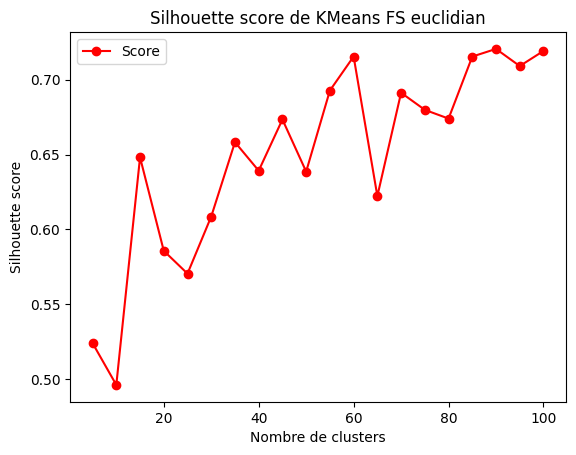

In [ ]:
tab_eucl = score_tab.copy()
tab_eucl.insert(0, "FS euclidian")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("Silhouette score de KMeans FS euclidian")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans from scratch manhattan ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'manhattan')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = silhouette_score(coordonnees, preds, metric = 'manhattan')
    score_tab.append(score)
    print("Pour n_clusters = {}, silhouette score = {})".format(n, score))

### KMeans from scratch manhattan ###
For n_clusters = 5, silhouette score is 0.5679085342644852)
For n_clusters = 10, silhouette score is 0.6165849927393968)
For n_clusters = 15, silhouette score is 0.5835976134886875)
For n_clusters = 20, silhouette score is 0.6169757060620542)
For n_clusters = 25, silhouette score is 0.5790250274688434)
For n_clusters = 30, silhouette score is 0.6332439910168712)
For n_clusters = 35, silhouette score is 0.6214914117835185)
For n_clusters = 40, silhouette score is 0.7140245706108748)
For n_clusters = 45, silhouette score is 0.6947299194902425)
For n_clusters = 50, silhouette score is 0.683205047750598)
For n_clusters = 55, silhouette score is 0.6548714514055699)
For n_clusters = 60, silhouette score is 0.6564291541398503)
For n_clusters = 65, silhouette score is 0.7336912249606304)
For n_clusters = 70, silhouette score is 0.7162863746167965)
For n_clusters = 75, silhouette score is 0.6944985866712428)
For n_clusters = 80, silhouette score is 0.689932

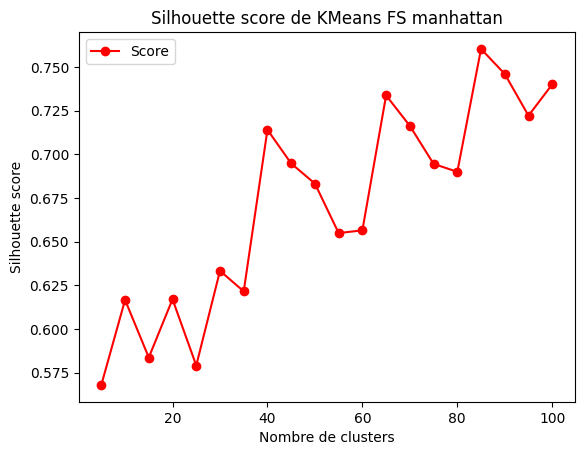

In [ ]:
tab_man = score_tab.copy()
tab_man.insert(0, "FS manhattan")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("Silhouette score de KMeans FS manhattan")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
warnings.filterwarnings("ignore")

print("### KMeans from scratch haversine ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'haversine')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = silhouette_score(coordonnees, preds, metric = 'haversine')
    score_tab.append(score)
    print("Pour n_clusters = {}, silhouette score = {})".format(n, score))

### KMeans from scratch haversine ###
For n_clusters = 5, silhouette score is 0.4092834139192097)
For n_clusters = 10, silhouette score is 0.49303095847543854)
For n_clusters = 15, silhouette score is 0.47643952660238)
For n_clusters = 20, silhouette score is 0.49360802896458694)
For n_clusters = 25, silhouette score is 0.5319364747435724)
For n_clusters = 30, silhouette score is 0.5277545737267513)
For n_clusters = 35, silhouette score is 0.5405056445850926)
For n_clusters = 40, silhouette score is 0.5765278996206322)
For n_clusters = 45, silhouette score is 0.5291054928905006)
For n_clusters = 50, silhouette score is 0.6090560662069742)
For n_clusters = 55, silhouette score is 0.6000324858998732)
For n_clusters = 60, silhouette score is 0.599776063129269)
For n_clusters = 65, silhouette score is 0.6317064493552267)
For n_clusters = 70, silhouette score is 0.5895869204319262)
For n_clusters = 75, silhouette score is 0.5942245093013473)
For n_clusters = 80, silhouette score is 0.610663

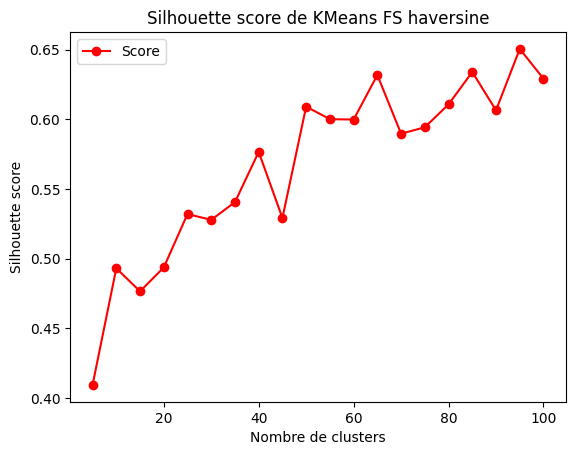

In [ ]:
tab_hav = score_tab.copy()
tab_hav.insert(0, "FS haversine")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("Silhouette score de KMeans FS haversine")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans sklearn ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.cluster_centers_

    score = silhouette_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n_clusters = {}, silhouette score = {})".format(n, score))

### KMeans sklearn ###
For n_clusters = 5, silhouette score is 0.6805726594578352)
For n_clusters = 10, silhouette score is 0.7288399347351949)
For n_clusters = 15, silhouette score is 0.7318033044684151)
For n_clusters = 20, silhouette score is 0.7460019203151125)
For n_clusters = 25, silhouette score is 0.7714156964900445)
For n_clusters = 30, silhouette score is 0.7836897604008736)
For n_clusters = 35, silhouette score is 0.7997245805006893)
For n_clusters = 40, silhouette score is 0.8181400865095383)
For n_clusters = 45, silhouette score is 0.8261606890582135)
For n_clusters = 50, silhouette score is 0.8426013956032596)
For n_clusters = 55, silhouette score is 0.8496186024115513)
For n_clusters = 60, silhouette score is 0.86506425492044)
For n_clusters = 65, silhouette score is 0.8749011681185183)
For n_clusters = 70, silhouette score is 0.8838137855086153)
For n_clusters = 75, silhouette score is 0.895308553574626)
For n_clusters = 80, silhouette score is 0.9034243853329968)
For n

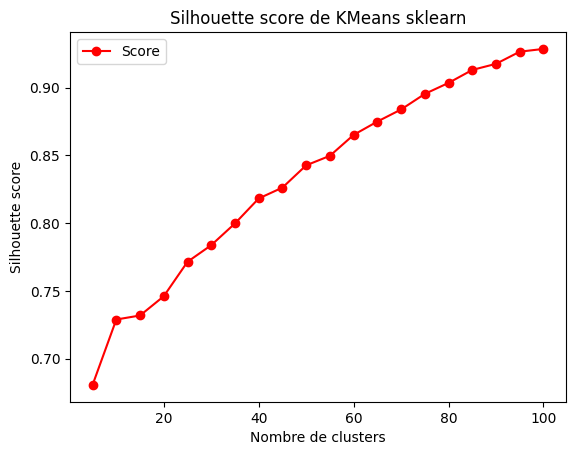

In [ ]:
tab_sk = score_tab.copy()
tab_sk.insert(0, "sklearn")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("Silhouette score de KMeans sklearn")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("Tableau des silhouette score en fonction de l'algorithme utilisé")
# Données du tableau
first_data = range_n_clusters.copy()
first_data.insert(0, "KMeans\cluster")
data = []
data.append(first_data)
data.append(tab_eucl)
data.append(tab_man)
data.append(tab_hav)
data.append(tab_sk)

# Afficher le tableau
table = tabulate(data, headers="firstrow", tablefmt="fancy_grid")
print(table)


Tableau des silhouette score en fonction de l'algorithme utilisé
╒══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ KMeans\cluster   │        5 │       10 │       15 │       20 │       25 │       30 │       35 │       40 │       45 │       50 │       55 │       60 │       65 │       70 │       75 │       80 │       85 │       90 │       95 │      100 │
╞══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ FS euclidian     │ 0.524034 │ 0.496133 │ 0.648167 │ 0.585722 │ 0.570483 │ 0.608618 │ 0.658289 │ 0.63923  │ 0.673448 │ 0.638631 │ 0.692787 │ 0.7155   │ 0.622274 │ 0.691299 │ 0.679876 │ 0.674044 │ 0.715473 │ 0.72

### 2.3.2 - Calinski-Harabasz Index

In [ ]:
print("### KMeans from scratch euclidean ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'euclidean')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = calinski_harabasz_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, calinski_harabasz_score = {})".format(n, score))

### KMeans from scratch euclidean ###
Pour n = 5, calinski_harabasz_score = 43746.49168267296)
Pour n = 10, calinski_harabasz_score = 32491.476119297145)
Pour n = 15, calinski_harabasz_score = 34727.707059852066)
Pour n = 20, calinski_harabasz_score = 81319.12848639123)
Pour n = 25, calinski_harabasz_score = 57098.633787576044)
Pour n = 30, calinski_harabasz_score = 22535.965104031402)
Pour n = 35, calinski_harabasz_score = 68888.63779120709)
Pour n = 40, calinski_harabasz_score = 25083.151697447633)
Pour n = 45, calinski_harabasz_score = 69264.25713355046)
Pour n = 50, calinski_harabasz_score = 66530.81214190465)
Pour n = 55, calinski_harabasz_score = 51999.44142773677)
Pour n = 60, calinski_harabasz_score = 51677.93220203687)
Pour n = 65, calinski_harabasz_score = 104166.9427052591)
Pour n = 70, calinski_harabasz_score = 14274.542589280865)
Pour n = 75, calinski_harabasz_score = 43158.123927646426)
Pour n = 80, calinski_harabasz_score = 25206.82235181385)
Pour n = 85, calinski_haraba

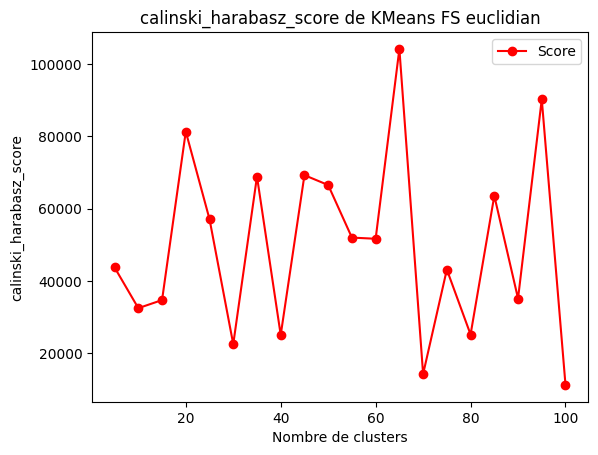

In [ ]:
tab_eucl = score_tab.copy()
tab_eucl.insert(0, "FS euclidian")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("calinski_harabasz_score de KMeans FS euclidian")
plt.xlabel("Nombre de clusters")
plt.ylabel("calinski_harabasz_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans from scratch manhattan ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'manhattan')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = calinski_harabasz_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, calinski_harabasz_score = {})".format(n, score))

### KMeans from scratch manhattan ###
Pour n = 5, calinski_harabasz_score = 45750.13977081971)
Pour n = 10, calinski_harabasz_score = 42321.31007256616)
Pour n = 15, calinski_harabasz_score = 26013.704321066652)
Pour n = 20, calinski_harabasz_score = 64759.42324080758)
Pour n = 25, calinski_harabasz_score = 51345.942317812944)
Pour n = 30, calinski_harabasz_score = 22029.738563783027)
Pour n = 35, calinski_harabasz_score = 17418.092721295692)
Pour n = 40, calinski_harabasz_score = 60286.87108238551)
Pour n = 45, calinski_harabasz_score = 53748.65271355293)
Pour n = 50, calinski_harabasz_score = 17534.346140987072)
Pour n = 55, calinski_harabasz_score = 15062.30662586135)
Pour n = 60, calinski_harabasz_score = 20052.542293340357)
Pour n = 65, calinski_harabasz_score = 15039.408101454314)
Pour n = 70, calinski_harabasz_score = 12258.364432197397)
Pour n = 75, calinski_harabasz_score = 13125.361913098324)
Pour n = 80, calinski_harabasz_score = 38933.842122232534)
Pour n = 85, calinski_har

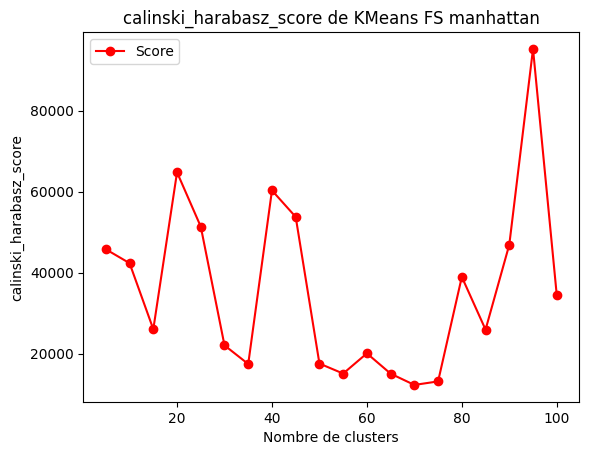

In [ ]:
tab_man = score_tab.copy()
tab_man.insert(0, "FS manhattan")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("calinski_harabasz_score de KMeans FS manhattan")
plt.xlabel("Nombre de clusters")
plt.ylabel("calinski_harabasz_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
warnings.filterwarnings("ignore")

print("### KMeans from scratch haversine ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'haversine')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = calinski_harabasz_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, calinski_harabasz_score = {})".format(n, score))

### KMeans from scratch haversine ###
Pour n = 5, calinski_harabasz_score = 59245.61244313118)
Pour n = 10, calinski_harabasz_score = 35985.356054760705)
Pour n = 15, calinski_harabasz_score = 20060.440693332697)
Pour n = 20, calinski_harabasz_score = 27752.510115322522)
Pour n = 25, calinski_harabasz_score = 23227.289713622744)
Pour n = 30, calinski_harabasz_score = 19948.947539771325)
Pour n = 35, calinski_harabasz_score = 22771.10522863476)
Pour n = 40, calinski_harabasz_score = 18061.226443839765)
Pour n = 45, calinski_harabasz_score = 16023.7556059838)
Pour n = 50, calinski_harabasz_score = 49990.230345611424)
Pour n = 55, calinski_harabasz_score = 22106.107914340788)
Pour n = 60, calinski_harabasz_score = 31499.63904482878)
Pour n = 65, calinski_harabasz_score = 43914.45254435807)
Pour n = 70, calinski_harabasz_score = 15617.28532117547)
Pour n = 75, calinski_harabasz_score = 13150.13865527875)
Pour n = 80, calinski_harabasz_score = 296747.11062166374)
Pour n = 85, calinski_harab

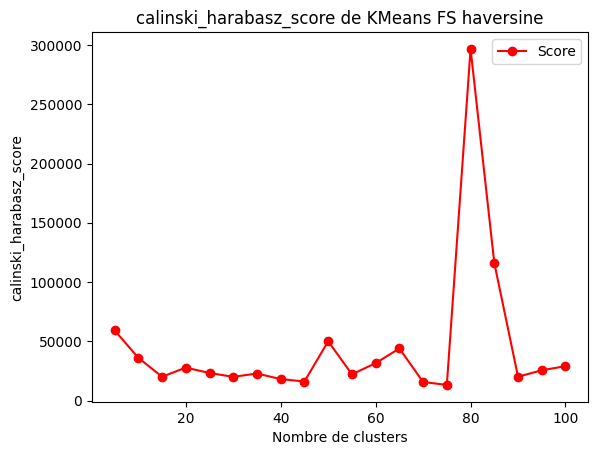

In [ ]:
tab_hav = score_tab.copy()
tab_hav.insert(0, "FS haversine")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("calinski_harabasz_score de KMeans FS haversine")
plt.xlabel("Nombre de clusters")
plt.ylabel("calinski_harabasz_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans sklearn ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.cluster_centers_

    score = calinski_harabasz_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, calinski_harabasz_score = {})".format(n, score))

### KMeans sklearn ###
Pour n = 5, calinski_harabasz_score = 101115.97915279637)
Pour n = 10, calinski_harabasz_score = 182979.91315198588)
Pour n = 15, calinski_harabasz_score = 236613.7979852689)
Pour n = 20, calinski_harabasz_score = 281621.48103746056)
Pour n = 25, calinski_harabasz_score = 350178.1835481918)
Pour n = 30, calinski_harabasz_score = 390981.74240691273)
Pour n = 35, calinski_harabasz_score = 444331.1666427718)
Pour n = 40, calinski_harabasz_score = 504734.8371847508)
Pour n = 45, calinski_harabasz_score = 562744.4924650955)
Pour n = 50, calinski_harabasz_score = 623050.073647479)
Pour n = 55, calinski_harabasz_score = 724039.7546209473)
Pour n = 60, calinski_harabasz_score = 816552.0800986815)
Pour n = 65, calinski_harabasz_score = 896840.28573775)
Pour n = 70, calinski_harabasz_score = 1007543.2499885287)
Pour n = 75, calinski_harabasz_score = 1102614.9965716684)
Pour n = 80, calinski_harabasz_score = 1258876.2597990048)
Pour n = 85, calinski_harabasz_score = 1398793

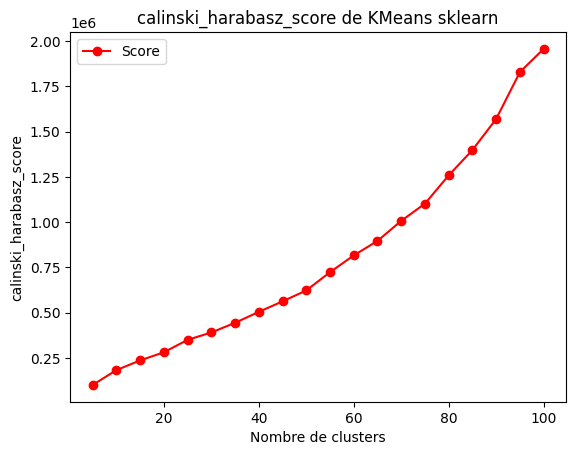

In [ ]:
tab_sk = score_tab.copy()
tab_sk.insert(0, "sklearn")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("calinski_harabasz_score de KMeans sklearn")
plt.xlabel("Nombre de clusters")
plt.ylabel("calinski_harabasz_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("Tableau des calinski_harabasz_score en fonction de l'algorithme utilisé")
# Données du tableau
first_data = range_n_clusters.copy()
first_data.insert(0, "KMeans\cluster")
data = []
data.append(first_data)
data.append(tab_eucl)
data.append(tab_man)
data.append(tab_hav)
data.append(tab_sk)

# Afficher le tableau
table = tabulate(data, headers="firstrow", tablefmt="fancy_grid")
print(table)


Tableau des calinski_harabasz_score en fonction de l'algorithme utilisé
╒══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═════════════════╤═════════════════╤══════════════════╤══════════════════╤═════════════════╤═════════════════╤═════════════════╕
│ KMeans\cluster   │        5 │       10 │       15 │       20 │       25 │       30 │       35 │       40 │       45 │       50 │       55 │       60 │       65 │              70 │              75 │               80 │               85 │              90 │              95 │             100 │
╞══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════════════╪═════════════════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ FS euclidian     │  43746.5 │  32491.5 │  34727.7 

### 2.3.3 - Davies-Bouldin Index

In [ ]:
print("### KMeans from scratch euclidean ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'euclidean')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = davies_bouldin_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, davies_bouldin_score = {})".format(n, score))

### KMeans from scratch euclidean ###
Pour n = 5, davies_bouldin_score = 0.7740112100790835)
Pour n = 10, davies_bouldin_score = 0.8117662809879209)
Pour n = 15, davies_bouldin_score = 0.743962252474944)
Pour n = 20, davies_bouldin_score = 0.9539875447483919)
Pour n = 25, davies_bouldin_score = 1.0093781198270113)
Pour n = 30, davies_bouldin_score = 0.9775390564235938)
Pour n = 35, davies_bouldin_score = 0.831136377808376)
Pour n = 40, davies_bouldin_score = 0.8215036388438894)
Pour n = 45, davies_bouldin_score = 1.0767981842485743)
Pour n = 50, davies_bouldin_score = 1.3165809037187162)
Pour n = 55, davies_bouldin_score = 0.6704068735742224)
Pour n = 60, davies_bouldin_score = 0.9808422151387512)
Pour n = 65, davies_bouldin_score = 1.0746871185705764)
Pour n = 70, davies_bouldin_score = 0.7673580826446118)
Pour n = 75, davies_bouldin_score = 0.7882626530418383)
Pour n = 80, davies_bouldin_score = 0.8495360117921317)
Pour n = 85, davies_bouldin_score = 1.1072853980745383)
Pour n = 90, 

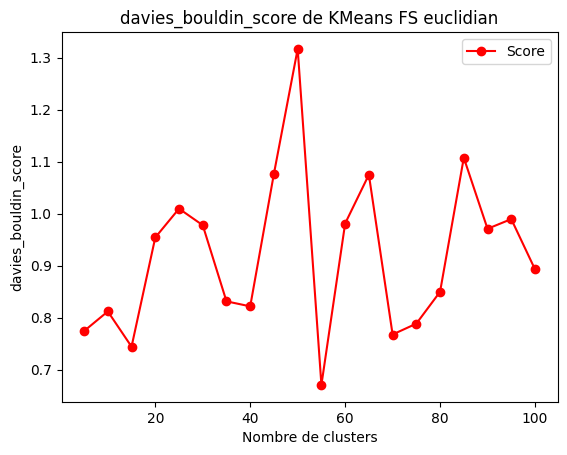

In [ ]:
tab_eucl = score_tab.copy()
tab_eucl.insert(0, "FS euclidian")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("davies_bouldin_score de KMeans FS euclidian")
plt.xlabel("Nombre de clusters")
plt.ylabel("davies_bouldin_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans from scratch manhattan ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'manhattan')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = davies_bouldin_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, davies_bouldin_score = {})".format(n, score))

### KMeans from scratch manhattan ###
Pour n = 5, davies_bouldin_score = 0.928439542408282)
Pour n = 10, davies_bouldin_score = 0.9904883654722062)
Pour n = 15, davies_bouldin_score = 1.2750609471229222)
Pour n = 20, davies_bouldin_score = 1.0692958011479419)
Pour n = 25, davies_bouldin_score = 0.8353422283270455)
Pour n = 30, davies_bouldin_score = 1.0169861022235194)
Pour n = 35, davies_bouldin_score = 0.6517212752891257)
Pour n = 40, davies_bouldin_score = 1.0258646731387828)
Pour n = 45, davies_bouldin_score = 0.9005405744397412)
Pour n = 50, davies_bouldin_score = 0.9130950937741004)
Pour n = 55, davies_bouldin_score = 0.8683308935055257)
Pour n = 60, davies_bouldin_score = 0.8067570809513551)
Pour n = 65, davies_bouldin_score = 0.9166109959821297)
Pour n = 70, davies_bouldin_score = 0.9227531039941359)
Pour n = 75, davies_bouldin_score = 0.8669299792444742)
Pour n = 80, davies_bouldin_score = 0.7979560140576519)
Pour n = 85, davies_bouldin_score = 1.0679465445478944)
Pour n = 90,

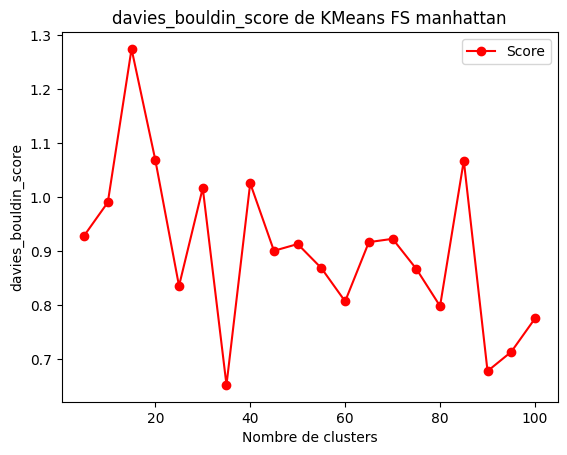

In [ ]:
tab_man = score_tab.copy()
tab_man.insert(0, "FS manhattan")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("davies_bouldin_score de KMeans FS manhattan")
plt.xlabel("Nombre de clusters")
plt.ylabel("davies_bouldin_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
warnings.filterwarnings("ignore")

print("### KMeans from scratch haversine ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans_from_scratch(n, distance = 'haversine')
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.centroides

    score = davies_bouldin_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, davies_bouldin_score = {})".format(n, score))

### KMeans from scratch haversine ###
Pour n = 5, davies_bouldin_score = 0.7720770492985459)
Pour n = 10, davies_bouldin_score = 1.0234897719923606)
Pour n = 15, davies_bouldin_score = 0.8712020619778689)
Pour n = 20, davies_bouldin_score = 0.8824894863763234)
Pour n = 25, davies_bouldin_score = 0.8881865478407241)
Pour n = 30, davies_bouldin_score = 1.0018185312304835)
Pour n = 35, davies_bouldin_score = 1.1948844657531723)
Pour n = 40, davies_bouldin_score = 1.3092102267429324)
Pour n = 45, davies_bouldin_score = 0.947915738132506)
Pour n = 50, davies_bouldin_score = 0.8968642567241533)
Pour n = 55, davies_bouldin_score = 0.98901187638401)
Pour n = 60, davies_bouldin_score = 0.9679970650735782)
Pour n = 65, davies_bouldin_score = 0.9237038824553224)
Pour n = 70, davies_bouldin_score = 1.0285839904054555)
Pour n = 75, davies_bouldin_score = 0.8840543949413282)
Pour n = 80, davies_bouldin_score = 0.9803860967174167)
Pour n = 85, davies_bouldin_score = 0.9631385565862737)
Pour n = 90, d

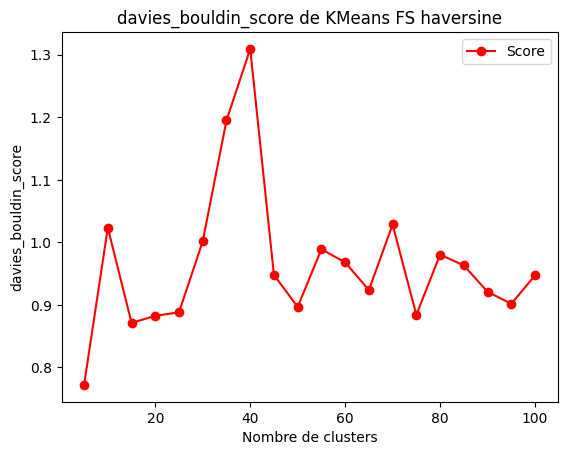

In [ ]:
tab_hav = score_tab.copy()
tab_hav.insert(0, "FS haversine")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("davies_bouldin_score de KMeans FS haversine")
plt.xlabel("Nombre de clusters")
plt.ylabel("davies_bouldin_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("### KMeans sklearn ###")
score_tab = []
for n in range_n_clusters:
    clusterer = KMeans(n_clusters=n)
    preds = clusterer.fit_predict(coordonnees)
    centers = clusterer.cluster_centers_

    score = davies_bouldin_score(coordonnees, preds)
    score_tab.append(score)
    print("Pour n = {}, davies_bouldin_score = {})".format(n, score))

### KMeans sklearn ###
Pour n = 5, davies_bouldin_score = 0.5459807461075883)
Pour n = 10, davies_bouldin_score = 0.48233873394975924)
Pour n = 15, davies_bouldin_score = 0.5848288607423158)
Pour n = 20, davies_bouldin_score = 0.5445743240186143)
Pour n = 25, davies_bouldin_score = 0.5442708680413979)
Pour n = 30, davies_bouldin_score = 0.5552113329200388)
Pour n = 35, davies_bouldin_score = 0.5160298005782347)
Pour n = 40, davies_bouldin_score = 0.5277565951128096)
Pour n = 45, davies_bouldin_score = 0.49305770723132347)
Pour n = 50, davies_bouldin_score = 0.4345196724071602)
Pour n = 55, davies_bouldin_score = 0.40397950470136446)
Pour n = 60, davies_bouldin_score = 0.423199627271922)
Pour n = 65, davies_bouldin_score = 0.38892016805876434)
Pour n = 70, davies_bouldin_score = 0.36190552890592786)
Pour n = 75, davies_bouldin_score = 0.3408572850758187)
Pour n = 80, davies_bouldin_score = 0.3302394014327278)
Pour n = 85, davies_bouldin_score = 0.30890803231825265)
Pour n = 90, davies_b

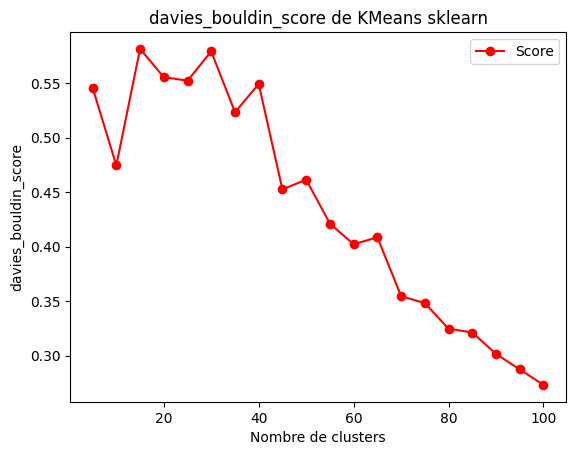

In [ ]:
tab_sk = score_tab.copy()
tab_sk.insert(0, "sklearn")
x = np.array(range_n_clusters)
y = np.array(score_tab)
plt.title("davies_bouldin_score de KMeans sklearn")
plt.xlabel("Nombre de clusters")
plt.ylabel("davies_bouldin_score")
plt.plot(x, y, color = "red", marker = "o", label = "Score")
plt.legend()
plt.show()

In [ ]:
print("Tableau des davies_bouldin_score en fonction de l'algorithme utilisé")
# Données du tableau
first_data = range_n_clusters.copy()
first_data.insert(0, "KMeans\cluster")
data = []
data.append(first_data)
data.append(tab_eucl)
data.append(tab_man)
data.append(tab_hav)
data.append(tab_sk)

# Afficher le tableau
table = tabulate(data, headers="firstrow", tablefmt="fancy_grid")
print(table)


Tableau des davies_bouldin_score en fonction de l'algorithme utilisé
╒══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ KMeans\cluster   │        5 │       10 │       15 │       20 │       25 │       30 │       35 │       40 │       45 │       50 │       55 │       60 │       65 │       70 │       75 │       80 │       85 │       90 │       95 │      100 │
╞══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ FS euclidian     │ 0.774011 │ 0.811766 │ 0.743962 │ 0.953988 │ 1.00938  │ 0.977539 │ 0.831136 │ 0.821504 │ 1.0768   │ 1.31658  │ 0.670407 │ 0.980842 │ 1.07469  │ 0.767358 │ 0.788263 │ 0.849536 │ 1.10729  │ 